In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable


In [0]:
# Useful examples of autoencoders (Pytorch)
# https://reyhaneaskari.github.io/AE.htm

# **Loading MNIST dataset**
# Applying Gaussian Noise

Option 1

In [0]:
simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])

# Option 1 -  Applying Gaussian noise within transformations during loading 
noise_factor = 0.3
trns_gaussian=transforms.Compose([
    transforms.ToTensor(), 
    # transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1)), # converts to [0,1] interval
    # transforms.Lambda(lambda tensor:tensor_round(tensor)),
    transforms.Lambda( lambda x: (x + noise_factor * torch.from_numpy(np.random.normal(loc=0.0, scale=1.0, size=x.shape))) ), # Applying noise
    transforms.Lambda( lambda x: np.clip(x, 0., 1.)),  # Removing >STD values (assigning 0 to values less than 0, and 1 for more than 1)
])

#let's download MNIST Train dataset
mnist_trainset = torchvision.datasets.MNIST('./mnist', train=True, download=True,  transform=simple) 
mnist_trainset_noisy = torchvision.datasets.MNIST('./mnist', train=True, download=True,  transform=trns_gaussian) 
# let's download MNIST Test dataset
# mnist_testset = torchvision.datasets.MNIST('./mnist', train=False, download=True,  transform=simple) 
# mnist_testset_noisy = torchvision.datasets.MNIST('./mnist', train=False, download=True,  transform=trns_gaussian) 

Option 2

In [0]:
# # Option 2 Applying Gaussian noise within transformations during loading using OOP
# class AddGaussianNoise(object):
#     def __init__(self, mean=0., std=1.):
#         self.std = std
#         self.mean = mean
#         self.noise_factor = 0.2
        
#     def __call__(self, tensor):
#         return tensor + torch.randn(tensor.size()) * self.noise_factor * self.std + self.mean
    
#     def __repr__(self):
#         return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# trns_gaussian_cls=transforms.Compose([
#     transforms.ToTensor(), # converts to [0,1] interval
#     transforms.Normalize((0.1307,), (0.3081,)),
#     AddGaussianNoise(0., 1.),
# ])

# #let's download MNIST Train dataset
# mnist_trainset = torchvision.datasets.MNIST('./mnist', train=True, download=True,  transform=trns_gaussian_cls) 
# #let's download MNIST Test dataset
# mnist_testset = torchvision.datasets.MNIST('./mnist', train=False, download=True,  transform=trns_gaussian_cls) 

Option 3

tensor([5])


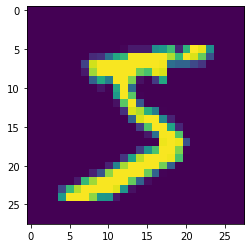

torch.Size([1, 1, 28, 28])
tensor([5])


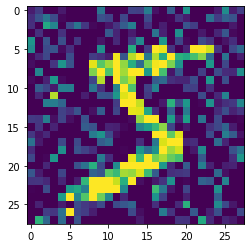

torch.Size([1, 1, 28, 28])


In [67]:
# now get data loader
train_loader = DataLoader(mnist_trainset, pin_memory=True, drop_last=True) # batch_size=128
train_loader_noisy = DataLoader(mnist_trainset_noisy, pin_memory=True, drop_last=True) # batch_size=128

# # Option 3 - Applying Gaussian noise After loading for full dataset at once
# noise_factor = 0.2
# test_loader_noisy= DataLoader(mnist_testset, pin_memory=True, drop_last=True) # batch_size=2
# test_loader_noisy.dataset.data = test_loader_noisy.dataset.data + noise_factor * torch.from_numpy(np.random.normal(loc=0.0, scale=1.0, size=test_loader_noisy.dataset.data.shape))
# test_loader_noisy.dataset.data = np.clip(test_loader_noisy.dataset.data, 0., 1.)

# Train dataset
for img, label in train_loader:
    # print('is pinned', img.is_pinned())
    # print(img, label)
    # print (label)
    print (label)
    plt.imshow(img[0][0])
    plt.show()
    print (img.shape)
    break

# Noisy Train dataset
for img, label in train_loader_noisy:
    print (label)
    plt.imshow(img[0][0])
    plt.show()
    print (img.shape)
    break    

# Model Training

In [0]:
class Autoencoder(nn.Module):
    ### Very Simple AutoEncoder
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.encoder = nn.Sequential(nn.Linear(28 * 28, encoding_dim),
                                     nn.ReLU(inplace=True))
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.decoder = nn.Sequential(nn.Linear(encoding_dim, 28*28),
                                     nn.Sigmoid())

    ### More Advanced AutoEncoder
    # https://blog.keras.io/building-autoencoders-in-keras.html
    # def __init__(self):
    #     super().__init__()
        
    #     # PyTorch
    #     self.encoded = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), 
    #                                   nn.ReLU(inplace=True),
    #                                   nn.MaxPool2d(2, 2),
    #                                   nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    #                                   nn.ReLU(inplace=True),
    #                                   nn.MaxPool2d(2, 2))
        
    #     # Declare all the layers for classification
    #     self.decoded = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), 
    #                                   nn.ReLU(inplace=True),
    #                                   nn.UpsamplingBilinear2d(2, 2),
    #                                   nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    #                                   nn.ReLU(inplace=True),
    #                                   nn.UpsamplingBilinear2d(2, 2),
    #                                   nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    #                                   nn.Sigmoid())
        # ### Start Tensorflow example
        # https://blog.keras.io/building-autoencoders-in-keras.html
        # x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        # x = MaxPooling2D((2, 2), padding='same')(x)
        # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        # encoded = MaxPooling2D((2, 2), padding='same')(x)

        # # at this point the representation is (7, 7, 32)
        # x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
        # x = UpSampling2D((2, 2))(x)
        # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        # x = UpSampling2D((2, 2))(x)
        # decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        # autoencoder = Model(input_img, decoded)
        # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        # # END Tensorflow 

### One more Advanced AutoEncoder example
# https://github.com/ReyhaneAskari/pytorch_experiments/blob/master/DAE.py
    # def __init__(self):
    #     super(autoencoder, self).__init__()
    #     self.encoder = nn.Sequential(
    #         nn.Linear(28 * 28, 256),
    #         nn.ReLU(True),
    #         nn.Linear(256, 64),
    #         nn.ReLU(True))
    #     self.decoder = nn.Sequential(
    #         nn.Linear(64, 256),
    #         nn.ReLU(True),
    #         nn.Linear(256, 28 * 28),
    #         nn.Sigmoid())

def forward(self, x):
        x = self.encoder(x)
        # output layer (sigmoid for scaling from 0 to 1)
        x = self.decoder(x)
        return x



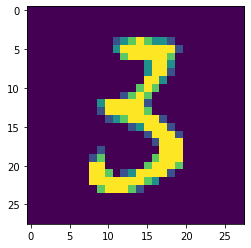

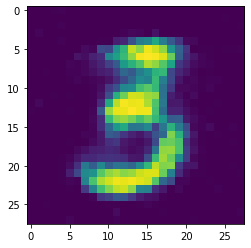

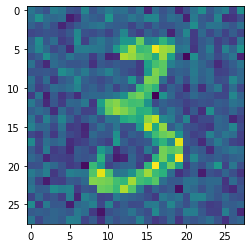

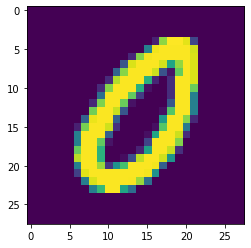

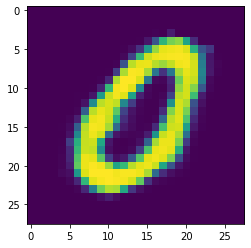

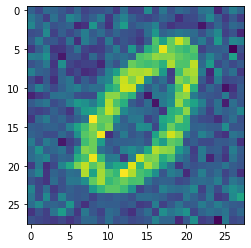

In [56]:
model = Autoencoder(encoding_dim=32).cpu()
print (model)
# specify loss function
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

noise_factor = 0.2
# now get data loader
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True, pin_memory=True, drop_last=True)

def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x

# number of epochs to train the model
n_epochs = 5

for epoch in range(n_epochs):
  ###################
  # train the model #
  ###################
  for img, label in train_loader:
    # flattening
    img = img.view(img.size(0), -1)
    # add noise
    noisy_img = img + noise_factor * torch.randn(img.size())
    
    # ===================forward=====================
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(noisy_img)
    # calculate the loss
    loss = criterion(output, img)
    # ===================backward====================
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    
  if epoch % 3 == 0:
    x = to_img(img.cpu().data)
    x_hat = to_img(output.cpu().data)
    x_noisy = to_img(noisy_img.cpu().data)
    
    plt.imshow(x[0][0])
    plt.show()
    plt.imshow(x_hat[0][0])
    plt.show()
    plt.imshow(x_noisy[0][0])
    plt.show()

# Model Using - Noise Removing on Test Dataset

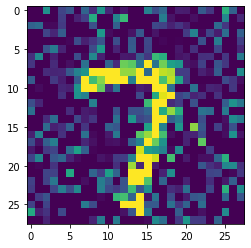

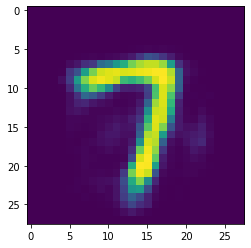

In [70]:
trns_gaussian=transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
    #transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1)),
    #transforms.Lambda(lambda tensor:tensor_round(tensor)),
    transforms.Lambda( lambda x: (x + noise_factor * torch.from_numpy(np.random.normal(loc=0.0, scale=1.0, size=x.shape))) ), # Applying noise
    transforms.Lambda( lambda x: np.clip(x, 0., 1.)),  # Removing >STD values (assigning 0 to values less than 0, and 1 for more than 1)
])
mnist_testset_noisy = torchvision.datasets.MNIST('./mnist', train=False, download=True,  transform=trns_gaussian) 

# now get data loader
test_loader_noisy = DataLoader(mnist_testset_noisy, pin_memory=True, shuffle=True, drop_last=True) # batch_size=2

# Noisy Test dataset
for img, label in test_loader_noisy:
    plt.imshow(img[0][0])
    plt.show()
    
    img = img.view(img.size(0), -1)
    
    # Predicting - Removing Noise
    output = model(img.float())
    
    x_hat = to_img(output.cpu().data)
    plt.imshow(x_hat[0][0])
    plt.show()
    break

